In [ ]:
#| default_exp datasets

In [ ]:
#| export
from itertools import zip_longest
import math
from operator import itemgetter

import fastcore.all as fc
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import default_collate

In [ ]:
import logging
from operator import itemgetter

from datasets import load_dataset, load_dataset_builder
import matplotlib as mpl
from torch.utils.data import DataLoader
import torchvision.transforms.functional as TF

In [ ]:
torch.set_printoptions(precision=2, linewidth=180, sci_mode=False)
torch.manual_seed(1103)
mpl.rcParams["image.cmap"] = "gray"

In [ ]:
logging.disable(logging.WARNING)

# Hugging Face Datasets

In [ ]:
load_dataset_builder?

Signature:
load_dataset_builder(
    path: str,
    name: Optional[str] = None,
    data_dir: Optional[str] = None,
    data_files: Union[str, Sequence[str], Mapping[str, Union[str, Sequence[str]]], NoneType] = None,
    cache_dir: Optional[str] = None,
    features: Optional[datasets.features.features.Features] = None,
    download_config: Optional[datasets.download.download_config.DownloadConfig] = None,
    download_mode: Union[datasets.download.download_manager.DownloadMode, str, NoneType] = None,
    revision: Union[str, datasets.utils.version.Version, NoneType] = None,
    token: Union[bool, str, NoneType] = None,
    use_auth_token='deprecated',
    storage_options: Optional[Dict] = None,
    **config_kwargs,
) -> datasets.builder.DatasetBuilder
Docstring:
Load a dataset builder from the Hugging Face Hub, or a local dataset. A dataset builder can be used to inspect general information that is required to build a dataset (cache directory, config, dataset info, etc.)
without downl

In [ ]:
name = "fashion_mnist"
ds_builder = load_dataset_builder(name)
ds_builder

<datasets_modules.datasets.fashion_mnist.0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48.fashion_mnist.FashionMnist>

In [ ]:
print(ds_builder.info.description)

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of
60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image,
associated with a label from 10 classes. We intend Fashion-MNIST to serve as a direct drop-in
replacement for the original MNIST dataset for benchmarking machine learning algorithms.
It shares the same image size and structure of training and testing splits.



In [ ]:
ds_builder.info.features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)}

In [ ]:
ds_builder.info.splits

{'train': SplitInfo(name='train', num_bytes=31296607, num_examples=60000, shard_lengths=None, dataset_name='fashion_mnist'),
 'test': SplitInfo(name='test', num_bytes=5233810, num_examples=10000, shard_lengths=None, dataset_name='fashion_mnist')}

In [ ]:
ds = load_dataset(name)

In [ ]:
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [ ]:
ds["train"][0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
 'label': 9}

In [ ]:
x, y = ds_builder.info.features

In [ ]:
train, test = ds["train"], ds["test"]
example = train[0]

In [ ]:
print(example[y])
example[x]

9


In [ ]:
xb = train[:5][x]
yb = train[:5][y]

In [ ]:
" ".join(filter(lambda x: x[0] != "_", dir(train.features[y])))

'cast_storage dtype encode_example id int2str names names_file num_classes pa_type str2int'

In [ ]:
feature_y = train.features[y]

In [ ]:
feature_y.int2str(yb)

['Ankle boot',
 'T - shirt / top',
 'T - shirt / top',
 'Dress',
 'T - shirt / top']

In [ ]:
yb

[9, 0, 0, 3, 0]

In [ ]:
train[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
 'label': 9}

In [ ]:
def collate_fn(b):
    return {
        x: torch.stack([TF.to_tensor(i[x]) for i in b]),
        y: torch.tensor([i[y] for i in b])
    }

In [ ]:
b = collate_fn([train[i] for i in range(3)])
b[x].shape, b[y].shape

(torch.Size([3, 1, 28, 28]), torch.Size([3]))

In [ ]:
dl = DataLoader(train, batch_size=8, collate_fn=collate_fn)

In [ ]:
b = next(iter(dl))

In [ ]:
def transforms(b):
    b[x] = [TF.to_tensor(i) for i in b[x]]
    return b

In [ ]:
train.with_transform?

Signature:
train.with_transform(
    transform: Optional[Callable],
    columns: Optional[List] = None,
    output_all_columns: bool = False,
)
Docstring:
Set `__getitem__` return format using this transform. The transform is applied on-the-fly on batches when `__getitem__` is called.

As [`~datasets.Dataset.set_format`], this can be reset using [`~datasets.Dataset.reset_format`].

Contrary to [`~datasets.Dataset.set_transform`], `with_transform` returns a new [`Dataset`] object.

Args:
    transform (`Callable`, `optional`):
        User-defined formatting transform, replaces the format defined by [`~datasets.Dataset.set_format`].
        A formatting function is a callable that takes a batch (as a `dict`) as input and returns a batch.
        This function is applied right before returning the objects in `__getitem__`.
    columns (`List[str]`, `optional`):
        Columns to format in the output.
        If specified, then the input batch of the transform only contains those columns

In [ ]:
traint = train.with_transform(transforms)

In [ ]:
dl = DataLoader(traint, batch_size=8)
b = next(iter(dl))
b[x].shape

torch.Size([8, 1, 28, 28])

In [ ]:
def _transforms(b):
    b[x] = [TF.to_tensor(i) for i in b[x]]

In [ ]:
#| export
def inplace(f):
    def _f(x):
        f(x)
        return x
    return _f

In [ ]:
transformi = inplace(_transforms)

In [ ]:
traint = train.with_transform(transformi)
dl = DataLoader(traint, batch_size=8)
b = next(iter(dl))
b[x].shape

torch.Size([8, 1, 28, 28])

In [ ]:
@inplace
def transformi(b):
    b[x] = [TF.to_tensor(i) for i in b[x]]

In [ ]:
traint = train.with_transform(transformi)
dl = DataLoader(traint, batch_size=8)
b = next(iter(dl))
b[x].shape

torch.Size([8, 1, 28, 28])

In [ ]:
itemgetter?

Init signature: itemgetter(self, /, *args, **kwargs)
Docstring:     
itemgetter(item, ...) --> itemgetter object

Return a callable object that fetches the given item(s) from its operand.
After f = itemgetter(2), the call f(r) returns r[2].
After g = itemgetter(2, 5, 3), the call g(r) returns (r[2], r[5], r[3])
File:           ~/miniforge3/envs/fastai/lib/python3.11/operator.py
Type:           type
Subclasses:     

In [ ]:
class D:
    def __getitem__(self, k):
        if k == "a": return 1
        elif k == "b": return 2
        else: return self

cd = D()
dd = {"a":3, "b":4, 2:"a"}
ig = itemgetter("a", "b", 2)


In [ ]:
ig(cd)

(1, 2, <__main__.D>)

In [ ]:
ig(dd)

(3, 4, 'a')

In [ ]:
try:
    ig(dict())
except Exception as e:
    print(type(e), e)

<class 'KeyError'> 'a'


In [ ]:
default_collate([
    {"a": 1, "b": 2},
    {"a": 3, "b": 4},
])

{'a': tensor([1, 3]), 'b': tensor([2, 4])}

In [ ]:
ig = itemgetter(*train.features)
ig

operator.itemgetter('image', 'label')

In [ ]:
cb = default_collate([traint[0], traint[1]])
cb

{'image': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]]),
 'label': tensor([9, 0])}

In [ ]:
ig(cb)

(tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]]),
 tensor([9, 0]))

In [ ]:
#| export
def collate_dict(ds):
    ig = itemgetter(*ds.features)
    def _f(x):
        return ig(default_collate(x))
    return _f

In [ ]:
dld = DataLoader(traint, batch_size=8, collate_fn=collate_dict(traint))
xb, yb = next(iter(dld))
xb.shape, yb.shape

(torch.Size([8, 1, 28, 28]), torch.Size([8]))

# Plotting images

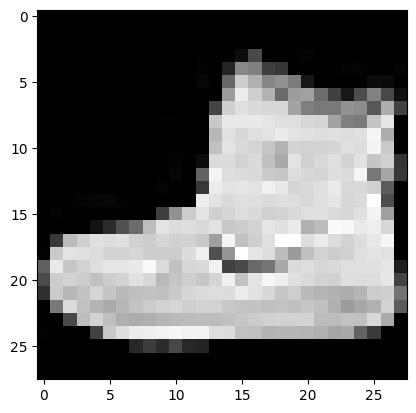

In [ ]:
# img = next(iter(dl))[x][0]
img = xb[0]
plt.imshow(img[0])
plt.show()

In [ ]:
fc.delegates?

Signature: fc.delegates(to: function = None, keep=False, but: list = None)
Docstring: Decorator: replace `**kwargs` in signature with params from `to`
File:      ~/miniforge3/envs/fastai/lib/python3.11/site-packages/fastcore/meta.py
Type:      function

In [ ]:
isinstance?

Signature: isinstance(obj, class_or_tuple, /)
Docstring:
Return whether an object is an instance of a class or of a subclass thereof.

A tuple, as in ``isinstance(x, (A, B, ...))``, may be given as the target to
check against. This is equivalent to ``isinstance(x, A) or isinstance(x, B)
or ...`` etc.
Type:      builtin_function_or_method

In [ ]:
#| export

@fc.delegates(plt.Axes.imshow)
def show_image(im, ax=None, figsize=None, title=None, **kwargs):
    if isinstance(im, torch.Tensor):
        im = im.detach().cpu()
        if len(im.shape) == 3:
            im = im.permute(1, 2, 0)
    elif not isinstance(im, np.ndarray):
        im = np.array(im)
    if im.shape[-1] == 1:
        im = im[..., 0]
    if ax is None:
        _, ax = plt.subplots(figsize=figsize)

    ax.imshow(im, **kwargs)
    if title is not None:
        ax.set_title(title)
    ax.axis("off")

    return ax

In [ ]:
help(show_image)

Help on function show_image in module __main__:

show_image(im, ax=None, figsize=None, title=None, *, cmap=None, norm=None, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, interpolation_stage=None, filternorm=True, filterrad=4.0, resample=None, url=None, data=None)



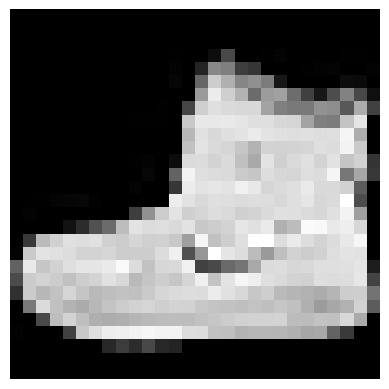

In [ ]:
_ = show_image(img)

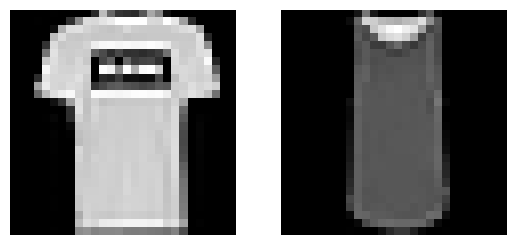

In [ ]:
_, ax = plt.subplots(1, 2)
show_image(xb[1], ax[0])
_ = show_image(xb[2], ax[1])

In [ ]:
plt.subplots

<function matplotlib.pyplot.subplots(nrows: 'int' = 1, ncols: 'int' = 1, *, sharex: "bool | Literal['none', 'all', 'row', 'col']" = False, sharey: "bool | Literal['none', 'all', 'row', 'col']" = False, squeeze: 'bool' = True, width_ratios: 'Sequence[float] | None' = None, height_ratios: 'Sequence[float] | None' = None, subplot_kw: 'dict[str, Any] | None' = None, gridspec_kw: 'dict[str, Any] | None' = None, **fig_kw) -> 'tuple[Figure, Any]'>

In [ ]:
#| export
@fc.delegates(plt.subplots)
def subplots(
    nrows: int = 1,  # Number of rows to create
    ncols: int = 1,  # Number of cols to create
    figsize: tuple = None,  # Size of the whole figure (width, height)
    imsize: int = 3,  # Size of eaxh image,
    suptitle: str = None,  # Title to use for the figure
    **kwargs
):  # fig and axs
    """A figure and subplots to display `nrows`x`ncols` images of size `imsize`."""
    if figsize is None:
        figsize = (ncols * imsize, nrows * imsize)
    fig, ax = plt.subplots(nrows, ncols, figsize=figsize, **kwargs)
    if suptitle is not None:
        fig.suptitle(suptitle)
    if nrows == ncols == 1:
        ax = np.array([ax])
    return fig, ax

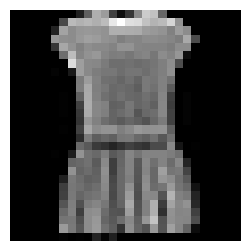

In [ ]:
fig, ax = subplots()
_ = show_image(xb[3], ax[0])

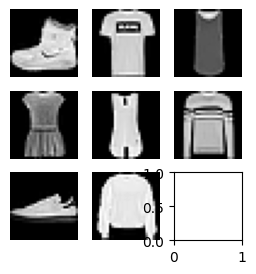

In [ ]:
fig, ax = subplots(3, 3, imsize=1)
for i, a in zip(xb[:8], ax.flat):
    show_image(i, a)

In [ ]:
#| export
@fc.delegates(subplots)
def get_grid(
    n: int,  # Number of axes
    nrows: int = None,  # Number of rows
    ncols: int = None,  # Number of cols
    title: str = None,  # Title of the figure
    weight: str = "bold",  # Title font weight
    size: int = 16,  # Title font size
    **kwargs
):  # fig and axs
    """Return a grid of at least `n` axes, `nrows`x`ncols`."""
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
    if nrows is None:
        nrows = math.ceil(n / ncols)
    if ncols is None:
        ncols = math.ceil(n / nrows)

    fig, ax = subplots(nrows, ncols, **kwargs)
    n = nrows * ncols
    for i in range(n):
        ax.flat[i].set_axis_off()
    if title is not None:
        fig.title(title, weight=weight, size=size)
    return fig, ax

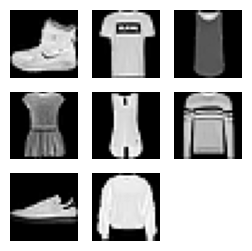

In [ ]:
fig, ax = get_grid(9, 3, imsize=1)
for i, a in zip(xb[:8], ax.flat):
    show_image(i, a)

In [ ]:
#| export
@fc.delegates(subplots)
def show_images(
    ims: list,  # Images to display
    nrows: int = None,  # Number of rows to show
    ncols: int = None,  # Number of cols to show
    titles: list = None,  # Titles for each image
    **kwargs
):
    """Display `ims` in a grid `nrows`x`ncols` with `titles`."""
    _, ax = get_grid(len(ims), nrows, ncols, **kwargs)
    for img, title, a in zip_longest(ims, titles or [], ax.flat):
        show_image(img, ax=a, title=title)

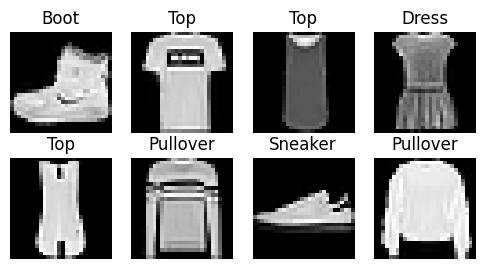

In [ ]:
show_images(xb, imsize=1.5, titles=list(map(lambda x: x.split()[-1].title(), feature_y.int2str(yb))))

# Export

In [ ]:
import nbdev; nbdev.nbdev_export()